In [30]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [31]:
strSource = r"D:\ML\data\StadtteilprofileBerichtsjahr2018_endversion.csv"
df = pd.read_csv(strSource, sep=';', header=0, encoding='iso-8859-1')

In [32]:
newIndex = []
for i in df.index:
    i += 1
    newIndex.append("ST" + str(i))

df['id'] = newIndex
df = df.set_index('id')

In [33]:
for key, value in df.iteritems():
    if re.search('_rel', key) != None:
        df.loc[:,[key]] = (df.loc[:,[key]] / 100.0).round(3)

In [34]:
for key, value in df.iteritems():
    if re.search('Stadtteil', key) != None:
        pass
    elif re.search('_rel', key) != None:
        pass
    else:
        maximum = df.loc[:,[key]].max()
        df.loc[:,[key]] = (df.loc[:,[key]] / maximum).round(3)

In [35]:
df = df.dropna(axis='columns')

In [36]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

In [37]:
methode='complete'; distanz='cosine'
dfc = df.loc[:,df.columns.difference(['Stadtteil'])]
model = AgglomerativeClustering(n_clusters=None, affinity=distanz, linkage=methode, distance_threshold=0)
model = model.fit(dfc)

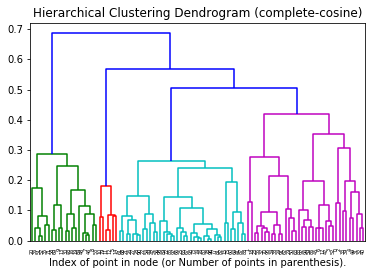

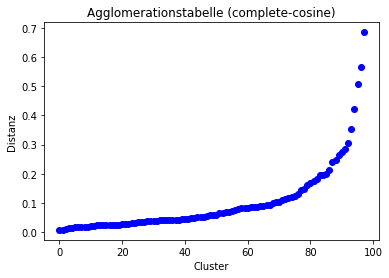

In [38]:
#Dendrogram
plt.figure()
plt.title('Hierarchical Clustering Dendrogram '+ '(' + methode + '-' + distanz + ')')
plot_dendrogram(model, truncate_mode='level', p=10)
plt.xlabel("Index of point in node (or Number of points in parenthesis).")
    
#Agglomerationstabelle
plt.figure()
plt.title('Agglomerationstabelle ' + '(' + methode + '-' + distanz + ')')
plt.plot(model.distances_, "ob")
plt.xlabel('Cluster')
plt.ylabel('Distanz')
plt.show()

In [39]:
clusterZahl=6
model = AgglomerativeClustering(n_clusters=clusterZahl,  affinity=distanz, linkage=methode, distance_threshold=None)
cluster = model.fit_predict(dfc)

dfc['Cluster'] = pd.Series(cluster, index=dfc.index)

In [40]:
dfm = pd.merge(df, dfc.loc[:,['Cluster']], on='id')
dfm.to_csv(r"D:\ML\work\StadtteilprofileBerichtsjahr2018_4.csv", sep=';', na_rep='NaN', index=True)

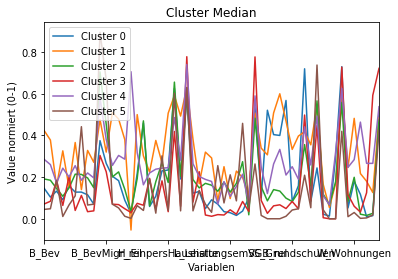

In [41]:
dfSeries = pd.DataFrame()
for i in range(model.n_clusters_):
    dfc_plot = dfc.loc[dfc['Cluster'] == i]
    dfc_plot = dfc_plot.loc[:,df.columns.difference(['Cluster','Stadtteil'])]
    s = dfc_plot.median().round(3)
    s.name = 'Cluster ' + str(i)
    s.plot.line()
    dfSeries = dfSeries.append(s)

filePath = "D:/ML/work/" + methode + "_" + distanz + "_" + str(clusterZahl) + ".csv"
dfSeries.to_csv(filePath, sep=';', na_rep='NaN', index=True)
 
plt.title('Cluster Median')
plt.xlabel('Variablen')
plt.ylabel('Value normiert (0-1)')
plt.legend()
plt.show()